<a href="https://colab.research.google.com/github/jalevano/tfm_uoc_datascience/blob/main/04_bodypix_evaluador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -*- coding: utf-8 -*-
"""
================================================================================
EVALUADOR BODYPIX - NOTEBOOK 2
================================================================================
Sistema de evaluacion para modelos BodyPix con estructura estandarizada
para comparacion de modelos de segmentacion de personas en fotografia de retrato.

CARACTERISTICAS PRINCIPALES:
- Procesamiento incremental con sistema de checkpoint robusto
- Gestion optima de memoria para Google Colab gratuito
- Guardado automatico despues de cada imagen procesada
- 3 modelos MobileNetV1 con multiplicadores 0.50, 0.75, 1.00
- 4 configuraciones de umbral de segmentacion
- Almacenamiento NPZ por fotografia con mascaras de probabilidad completas
- Segmentacion de partes del cuerpo (caracteristica unica de BodyPix)
- JSON ligero con metricas de rendimiento por umbral
- Visualizaciones estandarizadas

MODELOS DISPONIBLES:
1. MobileNetV1 0.50: Arquitectura ligera optimizada para velocidad
2. MobileNetV1 0.75: Balance entre velocidad y calidad de segmentacion
3. MobileNetV1 1.00: Maxima calidad de segmentacion disponible

CONFIGURACIONES DE UMBRAL:
Las configuraciones evaluan multiples umbrales de segmentacion para analizar
la sensibilidad del modelo a diferentes niveles de confianza:

1. ultra_sensible: [0.3, 0.4, 0.5] - Maxima deteccion de pixels
2. sensibilidad_alta: [0.4, 0.5, 0.6] - Alta sensibilidad
3. sensibilidad_media: [0.5, 0.65, 0.8] - Balance precision-recall
4. baja_sensibilidad: [0.7, 0.8, 0.9] - Alta confianza

ALMACENAMIENTO NPZ (por fotografia):
BodyPix genera mascaras de segmentacion continuas (valores 0-1) que representan
la probabilidad de que cada pixel pertenezca a una persona, y adicionalmente
puede segmentar partes del cuerpo. Se almacena:

Informacion de segmentacion de persona:
- mascara_probabilidad: Array (H, W) con valores 0.0-1.0 continuos
- mascaras_binarias_por_umbral: Dict con mascaras binarias para cada umbral
- dimensiones: Shape de la imagen procesada
- modelo_info: Metadatos del modelo usado

Informacion de partes del cuerpo (CARACTERISTICA UNICA de BodyPix):
- mascara_partes: Array (H, W) con IDs de partes 0-23, o -1 para fondo
- grupo_cara: Mascara binaria agrupada de cara
- grupo_torso: Mascara binaria agrupada de torso
- grupo_brazos: Mascara binaria agrupada de brazos
- grupo_manos: Mascara binaria agrupada de manos
- grupo_piernas: Mascara binaria agrupada de piernas
- grupo_pies: Mascara binaria agrupada de pies

NOTA SOBRE PARTES DEL CUERPO:
La segmentacion de partes del cuerpo es una caracteristica UNICA de BodyPix
que ningun otro modelo del TFM proporciona. Se almacena de forma LIGERA:
- La mascara de partes es int8 (mismo tamaño que la imagen)
- Se pre-calculan 6 grupos semanticos para fotografia de retrato
- Incremento de tamaño: ~7% adicional en NPZ comprimido
- Valor para el TFM: Permite analisis especificos de composicion de retratos

DIFERENCIAS CON OTROS MODELOS:
A diferencia de modelos de deteccion de instancias (YOLO, Mask2Former) o
generacion automatica (SAM2), BodyPix es un modelo de segmentacion semantica
que genera una unica mascara de probabilidad por imagen. No detecta instancias
individuales ni proporciona bounding boxes nativamente.

ESTRUCTURA DE SALIDA:
/TFM/2_Modelos/bodypix/{modelo}/{config}/resultados/
├── json/                           # Metricas por fotografia y umbral
├── mascaras/                       # NPZ con mascaras de probabilidad y partes
├── visualizaciones/                # Visualizaciones por fotografia
└── checkpoint.json                 # Estado del procesamiento

Entrada: Imagenes desde /TFM/0_Imagenes/
Salida: JSON, mascaras NPZ y visualizaciones en estructura organizada

Referencias:
- Papandreou et al. (2018) "PersonLab: Person Pose Estimation and Instance
  Segmentation with a Bottom-Up, Part-Based, Geometric Embedding Model"
- TensorFlow.js BodyPix: https://github.com/tensorflow/tfjs-models/tree/master/body-pix

Autor: Jesus L.
Proyecto: TFM - Evaluacion Comparativa de Tecnicas de Segmentacion
Universidad: Universidad Oberta de Cataluna (UOC)
Fecha: Octubre 2025
================================================================================

"""

'\n================================================================================\nEVALUADOR BODYPIX - NOTEBOOK 2\n================================================================================\nSistema de evaluacion para modelos BodyPix con estructura estandarizada\npara comparacion de modelos de segmentacion de personas en fotografia de retrato.\n\nCARACTERISTICAS PRINCIPALES:\n- Procesamiento incremental con sistema de checkpoint robusto\n- Gestion optima de memoria para Google Colab gratuito\n- Guardado automatico despues de cada imagen procesada\n- 3 modelos MobileNetV1 con multiplicadores 0.50, 0.75, 1.00\n- 4 configuraciones de umbral de segmentacion\n- Almacenamiento NPZ por fotografia con mascaras de probabilidad completas\n- Segmentacion de partes del cuerpo (caracteristica unica de BodyPix)\n- JSON ligero con metricas de rendimiento por umbral\n- Visualizaciones estandarizadas\n\nMODELOS DISPONIBLES:\n1. MobileNetV1 0.50: Arquitectura ligera optimizada para velocidad\n2.

In [3]:
# =============================================================================
# INSTALACION DE DEPENDENCIAS (EJECUTAR EN COLAB)
# =============================================================================

import subprocess
import sys

print("="*80)
print("INSTALANDO DEPENDENCIAS BODYPIX")
print("="*80)

# Orden correcto de instalacion para evitar conflictos
print("\n[1/5] Actualizando packaging...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "packaging>=24.2.0"])

print("[2/5] Instalando TensorFlow...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])

print("[3/5] Instalando tfjs-graph-converter...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tfjs-graph-converter"])

print("[4/5] Instalando tf-bodypix...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tf-bodypix"])

print("[5/5] Instalando librerias de procesamiento...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "opencv-python", "Pillow", "matplotlib"])

print("\n" + "="*80)
print("DEPENDENCIAS INSTALADAS CORRECTAMENTE")
print("="*80 + "\n")

# =============================================================================
# MONTAR GOOGLE DRIVE
# =============================================================================

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    IN_COLAB = True
    print("Google Drive montado correctamente\n")
except:
    IN_COLAB = False
    print("Entorno fuera de Google Colab\n")

INSTALANDO DEPENDENCIAS BODYPIX

[1/5] Actualizando packaging...
[2/5] Instalando TensorFlow...
[3/5] Instalando tfjs-graph-converter...
[4/5] Instalando tf-bodypix...
[5/5] Instalando librerias de procesamiento...

DEPENDENCIAS INSTALADAS CORRECTAMENTE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado correctamente



In [4]:
# =============================================================================
# IMPORTACIONES
# =============================================================================

import os
import gc
import time
import json
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from dataclasses import dataclass, asdict, field

import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tf_bodypix.api import download_model, load_model, BodyPixModelPaths

warnings.filterwarnings('ignore')

# Configurar TensorFlow para crecimiento dinamico de memoria GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configurada: {len(gpus)} dispositivo(s) disponible(s)")
    except RuntimeError as e:
        print(f"Error configurando GPU: {e}")
else:
    print("Ejecutando en CPU")

print("Librerias importadas correctamente\n")

Ejecutando en CPU
Librerias importadas correctamente



In [39]:
# =============================================================================
# CONFIGURACION
# =============================================================================

@dataclass
class ModeloBodyPix:
    """Informacion de un modelo BodyPix"""
    nombre: str
    nombre_corto: str
    path: Any  # BodyPixModelPaths enum
    arquitectura: str
    multiplicador: float
    descripcion: str

MODELOS_DISPONIBLES = {
    'mobilenet_v1_050': ModeloBodyPix(
        nombre='MobileNetV1 0.50',
        nombre_corto='mobilenet_v1_050',
        path=BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16,
        arquitectura='MobileNetV1',
        multiplicador=0.50,
        descripcion='Modelo ultraligero optimizado para velocidad'
    ),
    'mobilenet_v1_075': ModeloBodyPix(
        nombre='MobileNetV1 0.75',
        nombre_corto='mobilenet_v1_075',
        path=BodyPixModelPaths.MOBILENET_FLOAT_75_STRIDE_16,
        arquitectura='MobileNetV1',
        multiplicador=0.75,
        descripcion='Balance entre velocidad y calidad de segmentacion'
    ),
    # 'mobilenet_v1_100': ModeloBodyPix(
    #     nombre='MobileNetV1 1.00',
    #     nombre_corto='mobilenet_v1_100',
    #     path=BodyPixModelPaths.MOBILENET_FLOAT_100_STRIDE_16,
    #     arquitectura='MobileNetV1',
    #     multiplicador=1.00,
    #     descripcion='Maxima calidad de segmentacion disponible'
    # )
}

@dataclass
class ConfiguracionUmbrales:
    """
    Configuracion de umbrales de segmentacion para BodyPix.

    Los umbrales controlan que pixels se consideran como persona basandose
    en la probabilidad de segmentacion (valores 0.0 a 1.0).
    """
    nombre: str
    valores: List[float]
    descripcion: str

    def __post_init__(self):
        """Validacion de parametros"""
        if not all(0.0 <= v <= 1.0 for v in self.valores):
            raise ValueError("Los valores de umbral deben estar entre 0.0 y 1.0")

CONFIGURACIONES_UMBRALES = {
    'ultra_sensible': ConfiguracionUmbrales(
        nombre='ultra_sensible',
        valores=[0.10, 0.15, 0.20],
        descripcion='Maxima captura de la persona - Incluye bordes suaves (~55-66% area)'
    ),
    'sensibilidad_alta': ConfiguracionUmbrales(
        nombre='sensibilidad_alta',
        valores=[0.15, 0.20, 0.25],
        descripcion='Alta sensibilidad - Balance captura/precision (~50-60% area)'
    ),
    'sensibilidad_media': ConfiguracionUmbrales(
        nombre='sensibilidad_media',
        valores=[0.20, 0.30, 0.40],
        descripcion='Configuracion estandar para retrato - Precision optima (~40-55% area)'
    ),
    'baja_sensibilidad': ConfiguracionUmbrales(
        nombre='baja_sensibilidad',
        valores=[0.30, 0.40, 0.50],
        descripcion='Alta precision - Solo regiones de maxima confianza (~35-47% area)'
    )
}

@dataclass
class ConfiguracionEvaluacion:
    """Configuracion principal del sistema de evaluacion"""

    # Modelos a evaluar
    modelos_evaluar: List[str] = None  # None = todos los modelos

    # Configuraciones de umbrales a evaluar
    configs_umbrales: List[str] = None  # None = ['sensibilidad_media']

    # Rutas del sistema
    ruta_base: Path = Path("/content/drive/MyDrive/TFM")
    ruta_imagenes: Path = None
    ruta_salida: Path = None

    # Parametros de procesamiento
    max_dimension: int = 1024  # Dimension maxima para procesamiento
    pausa_entre_imagenes: float = 2.0  # Segundos entre imagenes
    pausa_entre_modelos: float = 5.0   # Segundos entre modelos

    def __post_init__(self):
        """Inicializacion de rutas por defecto"""
        if self.ruta_imagenes is None:
            self.ruta_imagenes = self.ruta_base / "0_Imagenes"
        if self.ruta_salida is None:
            self.ruta_salida = self.ruta_base / "2_Modelos" / "bodypix"
        if self.modelos_evaluar is None:
            self.modelos_evaluar = list(MODELOS_DISPONIBLES.keys())
        if self.configs_umbrales is None:
            self.configs_umbrales = ['sensibilidad_media']

In [35]:
# =============================================================================
# UTILIDADES
# =============================================================================

class Utilidades:
    """Utilidades para manejo de imagenes y archivos"""

    @staticmethod
    def cargar_imagen(ruta_imagen: Path, max_dimension: int = None) -> Tuple[np.ndarray, Dict]:
        """
        Carga una imagen y la convierte a RGB.

        CRÍTICO: BodyPix funciona MEJOR con imágenes grandes.
        NO redimensionar agresivamente. Solo si es absolutamente necesario.

        Args:
            ruta_imagen: Path a la imagen
            max_dimension: Dimensión máxima (usar None o valor alto tipo 4096)

        Returns:
            Tuple de (img_array_RGB, metadata)
        """
        # Cargar con OpenCV (BGR por defecto)
        img_bgr = cv2.imread(str(ruta_imagen))

        if img_bgr is None:
            raise ValueError(f"No se pudo cargar la imagen: {ruta_imagen}")

        # CRÍTICO: Convertir BGR -> RGB
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Obtener dimensiones originales
        alto_orig, ancho_orig = img_rgb.shape[:2]

        # Redimensionar SOLO si es excesivamente grande Y max_dimension está definido
        if max_dimension and max(ancho_orig, alto_orig) > max_dimension:
            ratio = max_dimension / max(ancho_orig, alto_orig)
            nuevo_ancho = int(ancho_orig * ratio)
            nuevo_alto = int(alto_orig * ratio)
            img_rgb = cv2.resize(
                img_rgb,
                (nuevo_ancho, nuevo_alto),
                interpolation=cv2.INTER_AREA
            )
            redimensionado = True
        else:
            redimensionado = False

        # Metadata
        alto_proc, ancho_proc = img_rgb.shape[:2]
        info = {
            'ancho_original': ancho_orig,
            'alto_original': alto_orig,
            'ancho_procesado': ancho_proc,
            'alto_procesado': alto_proc,
            'redimensionado': redimensionado,
            'factor_escala': ancho_proc / ancho_orig if redimensionado else 1.0
        }

        return img_rgb, info

    @staticmethod
    def liberar_memoria():
        """
        Libera memoria y limpia sesión de TensorFlow/Keras.
        """
        import gc
        gc.collect()

        try:
            import tensorflow as tf
            if tf.config.list_physical_devices('GPU'):
                tf.keras.backend.clear_session()
        except:
            pass

    @staticmethod
    def guardar_json(datos: Dict, ruta: Path):
        """
        Guarda un diccionario como archivo JSON.
        """
        ruta.parent.mkdir(parents=True, exist_ok=True)

        with open(ruta, 'w', encoding='utf-8') as f:
            json.dump(datos, f, indent=2, ensure_ascii=False)

    @staticmethod
    def calcular_hash_imagen(ruta: Path) -> str:
        """
        Calcula hash MD5 de una imagen.
        """
        import hashlib
        with open(ruta, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()[:16]

In [7]:
# =============================================================================
# GESTOR DE CHECKPOINT
# =============================================================================

class GestorCheckpoint:
    """
    Gestiona el estado del procesamiento para permitir reanudacion tras
    interrupciones. Mantiene registro de imagenes completadas por combinacion
    de modelo y configuracion de umbrales.
    """

    def __init__(self, ruta_checkpoint: Path):
        self.ruta_checkpoint = ruta_checkpoint
        self.checkpoint = self._cargar()

    def _cargar(self) -> Dict:
        """Carga checkpoint existente o crea uno nuevo"""
        if self.ruta_checkpoint.exists():
            with open(self.ruta_checkpoint, 'r') as f:
                return json.load(f)
        return {
            'imagenes_completadas': [],
            'fecha_inicio': datetime.now().isoformat()
        }

    def obtener_pendientes(self, todas_imagenes: List[str]) -> set:
        """Retorna conjunto de imagenes pendientes de procesar"""
        completadas = set(self.checkpoint.get('imagenes_completadas', []))
        return set(todas_imagenes) - completadas

    def marcar_completada(self, nombre_imagen: str):
        """Marca una imagen como completada y persiste el checkpoint"""
        if nombre_imagen not in self.checkpoint['imagenes_completadas']:
            self.checkpoint['imagenes_completadas'].append(nombre_imagen)
            self.checkpoint['ultima_actualizacion'] = datetime.now().isoformat()
            Utilidades.guardar_json(self.checkpoint, self.ruta_checkpoint)

In [14]:
class GestorMascaras:
    """
    Gestor para guardar y cargar mascaras de segmentacion en formato NPZ.

    Almacena mascaras binarias por umbral y opcionalmente informacion de
    partes del cuerpo (caracteristica unica de BodyPix).
    """

    # Grupos semanticos de partes del cuerpo para fotografia de retrato
    # IDs segun BodyPix: 0-23 representan diferentes partes anatomicas
    GRUPOS_PARTES_CUERPO = {
        'cara': [0, 1],           # left_face, right_face
        'torso': [2, 3, 4, 5],    # left/right_upper_arm_front/back
        'brazos': [6, 7, 8, 9],   # left/right_lower_arm_front/back
        'manos': [10, 11],        # left_hand, right_hand
        'piernas': [12, 13, 14, 15, 16, 17],  # upper/lower leg front/back
        'pies': [18, 19]          # left_foot, right_foot
    }

    def __init__(self, directorio_mascaras: Path):
        """
        Args:
            directorio_mascaras: Directorio donde guardar los archivos NPZ
        """
        self.directorio_mascaras = Path(directorio_mascaras)
        self.directorio_mascaras.mkdir(parents=True, exist_ok=True)

    def guardar_mascaras(
        self,
        mascara_probabilidad: np.ndarray,
        umbrales: List[float],
        nombre_imagen: str,
        metadatos: Dict,
        mascara_partes: np.ndarray = None,
        masks_por_umbral: Dict[float, np.ndarray] = None
    ) -> str:
        """
        Guarda mascaras en formato NPZ comprimido.

        Para BodyPix: guarda una mascara binaria POR CADA umbral evaluado,
        ya que el modelo no proporciona probabilidades continuas.

        Para otros modelos: genera mascaras binarias desde probabilidades continuas.

        Args:
            mascara_probabilidad: Mascara de referencia (probabilidades o umbral medio)
            umbrales: Lista de umbrales evaluados
            nombre_imagen: Nombre del archivo de imagen
            metadatos: Metadatos del modelo
            mascara_partes: Array opcional con IDs de partes del cuerpo (BodyPix)
            masks_por_umbral: Dict con mascaras por umbral (BodyPix solamente)

        Returns:
            Path completo del archivo NPZ guardado
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        nombre_base = Path(nombre_imagen).stem
        nombre_archivo = f"{nombre_base}_{timestamp}.npz"
        ruta_completa = self.directorio_mascaras / nombre_archivo

        # Preparar datos base
        datos_npz = {
            'mascara_probabilidad': mascara_probabilidad.astype(np.float32),
            'dimensiones': np.array(mascara_probabilidad.shape),
            'umbrales': np.array(umbrales),
            'modelo_nombre': metadatos.get('nombre_corto', 'unknown')
        }

        # Guardar mascaras por umbral
        if masks_por_umbral is not None:
            # BodyPix: usar las mascaras ya generadas para cada umbral
            for umbral, mask in masks_por_umbral.items():
                # Convertir a binario si no lo es ya
                mascara_binaria = (mask > 0.5).astype(np.uint8)
                datos_npz[f'umbral_{umbral}'] = mascara_binaria
        else:
            # Otros modelos: generar desde probabilidades continuas
            for umbral in umbrales:
                mascara_binaria = (mascara_probabilidad >= umbral).astype(np.uint8)
                datos_npz[f'umbral_{umbral}'] = mascara_binaria

        # Partes del cuerpo (solo BodyPix)
        if mascara_partes is not None:
            # Guardar mascara raw con IDs de partes
            datos_npz['mascara_partes'] = mascara_partes.astype(np.int8)

            # Generar mascaras agrupadas por grupos semanticos
            for nombre_grupo, ids_partes in self.GRUPOS_PARTES_CUERPO.items():
                mascara_grupo = np.isin(mascara_partes, ids_partes).astype(np.uint8)
                datos_npz[f'grupo_{nombre_grupo}'] = mascara_grupo

        # Guardar archivo NPZ comprimido
        np.savez_compressed(ruta_completa, **datos_npz)

        return str(ruta_completa)

    def cargar_mascaras(self, ruta_archivo: Path) -> Dict:
        """
        Carga mascaras desde un archivo NPZ.

        Args:
            ruta_archivo: Path al archivo NPZ

        Returns:
            Diccionario con todas las mascaras y metadatos
        """
        if not Path(ruta_archivo).exists():
            raise FileNotFoundError(f"Archivo no encontrado: {ruta_archivo}")

        data = np.load(ruta_archivo)

        # Extraer datos base
        resultado = {
            'mascara_probabilidad': data['mascara_probabilidad'],
            'dimensiones': tuple(data['dimensiones']),
            'umbrales': list(data['umbrales']),
            'modelo_nombre': str(data['modelo_nombre'])
        }

        # Extraer mascaras por umbral
        mascaras_umbrales = {}
        for key in data.files:
            if key.startswith('umbral_'):
                umbral_str = key.replace('umbral_', '')
                umbral = float(umbral_str)
                mascaras_umbrales[umbral] = data[key]
        resultado['mascaras_por_umbral'] = mascaras_umbrales

        # Extraer partes del cuerpo si existen
        if 'mascara_partes' in data:
            resultado['mascara_partes'] = data['mascara_partes']

            # Extraer grupos
            grupos = {}
            for nombre_grupo in self.GRUPOS_PARTES_CUERPO.keys():
                key = f'grupo_{nombre_grupo}'
                if key in data:
                    grupos[nombre_grupo] = data[key]

            if grupos:
                resultado['grupos_partes'] = grupos

        return resultado

    def obtener_informacion_archivo(self, ruta_archivo: Path) -> Dict:
        """
        Obtiene informacion basica de un archivo NPZ sin cargar las mascaras completas.

        Args:
            ruta_archivo: Path al archivo NPZ

        Returns:
            Diccionario con metadatos del archivo
        """
        if not Path(ruta_archivo).exists():
            raise FileNotFoundError(f"Archivo no encontrado: {ruta_archivo}")

        data = np.load(ruta_archivo)

        info = {
            'nombre_archivo': Path(ruta_archivo).name,
            'dimensiones': tuple(data['dimensiones']),
            'umbrales': list(data['umbrales']),
            'modelo_nombre': str(data['modelo_nombre']),
            'tiene_partes': 'mascara_partes' in data,
            'arrays_disponibles': sorted(data.files),
            'tamaño_bytes': Path(ruta_archivo).stat().st_size
        }

        return info

    def listar_archivos(self) -> List[Path]:
        """
        Lista todos los archivos NPZ en el directorio.

        Returns:
            Lista de paths a archivos NPZ
        """
        return sorted(self.directorio_mascaras.glob("*.npz"))

    def obtener_estadisticas_directorio(self) -> Dict:
        """
        Obtiene estadisticas del directorio de mascaras.

        Returns:
            Diccionario con estadisticas
        """
        archivos = self.listar_archivos()

        if not archivos:
            return {
                'total_archivos': 0,
                'tamaño_total_mb': 0.0,
                'modelos': []
            }

        tamaño_total = sum(f.stat().st_size for f in archivos)

        # Extraer modelos unicos
        modelos = set()
        for archivo in archivos:
            try:
                info = self.obtener_informacion_archivo(archivo)
                modelos.add(info['modelo_nombre'])
            except:
                pass

        return {
            'total_archivos': len(archivos),
            'tamaño_total_mb': round(tamaño_total / (1024 * 1024), 2),
            'modelos': sorted(list(modelos)),
            'directorio': str(self.directorio_mascaras)
        }

In [9]:
# =============================================================================
# GENERADOR DE VISUALIZACIONES
# =============================================================================

class GeneradorVisualizaciones:
    """Genera visualizaciones estandarizadas de resultados de segmentacion"""

    @staticmethod
    def generar_visualizacion(
        imagen: np.ndarray,
        mascara_probabilidad: np.ndarray,
        umbral_vis: float,
        ruta_salida: Path,
        titulo: str
    ):
        """
        Genera visualizacion de 2 paneles: imagen original y segmentacion.

        Args:
            imagen: Array RGB de la imagen original
            mascara_probabilidad: Mascara de probabilidad (0.0-1.0)
            umbral_vis: Umbral usado para la visualizacion
            ruta_salida: Path donde guardar la visualizacion
            titulo: Titulo para la figura
        """
        ruta_salida.parent.mkdir(parents=True, exist_ok=True)

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Panel 1: Imagen original
        axes[0].imshow(imagen)
        axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Panel 2: Segmentacion con overlay
        axes[1].imshow(imagen)

        # Aplicar umbral para visualizacion
        mascara_binaria = mascara_probabilidad >= umbral_vis

        # Crear overlay verde semi-transparente para persona
        overlay = np.zeros_like(imagen)
        overlay[mascara_binaria] = [0, 255, 0]

        axes[1].imshow(overlay, alpha=0.4)
        axes[1].set_title(
            f'Segmentacion (umbral={umbral_vis})',
            fontsize=12,
            fontweight='bold'
        )
        axes[1].axis('off')

        # Calcular y mostrar estadisticas
        area_persona = mascara_binaria.sum()
        area_total = mascara_binaria.size
        porcentaje = (area_persona / area_total) * 100

        info_text = f"Area persona: {porcentaje:.1f}%\n"
        info_text += f"Pixels: {area_persona:,} / {area_total:,}"

        axes[1].text(
            0.02, 0.98, info_text,
            transform=axes[1].transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10,
            family='monospace'
        )

        plt.suptitle(titulo, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(ruta_salida, dpi=100, bbox_inches='tight')
        plt.close()


In [41]:
class ProcesadorBodyPix:
    """
    Procesador para BodyPix - VERSIÓN DEFINITIVA CON DEBUG DE PARTES

    Procesa imágenes SIN redimensionar (BodyPix funciona mejor con imágenes grandes).
    Los valores de get_mask() son 0-1 (int32), NO 0-255.
    Incluye debug detallado de partes del cuerpo detectadas.
    """

    # Mapeo de IDs de partes del cuerpo de BodyPix
    BODYPIX_PART_IDS = {
        -1: 'fondo',
        0: 'left_face',
        1: 'right_face',
        2: 'left_upper_arm_front',
        3: 'left_upper_arm_back',
        4: 'right_upper_arm_front',
        5: 'right_upper_arm_back',
        6: 'left_lower_arm_front',
        7: 'left_lower_arm_back',
        8: 'right_lower_arm_front',
        9: 'right_lower_arm_back',
        10: 'left_hand',
        11: 'right_hand',
        12: 'torso_front',
        13: 'torso_back',
        14: 'left_upper_leg_front',
        15: 'left_upper_leg_back',
        16: 'right_upper_leg_front',
        17: 'right_upper_leg_back',
        18: 'left_lower_leg_front',
        19: 'left_lower_leg_back',
        20: 'right_lower_leg_front',
        21: 'right_lower_leg_back',
        22: 'left_foot',
        23: 'right_foot'
    }

    def __init__(self, modelo_info: ModeloBodyPix, config: ConfiguracionEvaluacion):
        self.modelo_info = modelo_info
        self.config = config
        self.model = None

    def cargar_modelo(self):
        """Descarga y carga el modelo BodyPix"""
        print(f"  Cargando modelo {self.modelo_info.nombre}...")
        model_path = download_model(self.modelo_info.path)
        self.model = load_model(model_path)
        print(f"  Modelo cargado correctamente")

    def procesar_imagen(
        self,
        img_path: Path,
        umbrales: List[float],
        ruta_salida: Path
    ) -> Tuple[Dict, np.ndarray, np.ndarray]:
        """
        Procesa una imagen con BodyPix.

        CRÍTICO: NO redimensionar agresivamente. BodyPix funciona mejor con imágenes grandes.
        Los valores de get_mask() son 0-1 (int32), NO 0-255.
        """
        # Cargar imagen SIN redimensionar (o con límite muy alto)
        img_array, info_img = Utilidades.cargar_imagen(img_path, max_dimension=4096)

        print(f"    Input - Shape: {img_array.shape}, "
              f"Dtype: {img_array.dtype}, "
              f"Range: [{img_array.min()}, {img_array.max()}]")

        # Tiempo total de inferencia
        tiempo_total_inicio = time.time()

        # Una inferencia por cada umbral (limitación de tf-bodypix)
        print(f"    Procesando {len(umbrales)} umbrales (inferencia por umbral)")
        masks_por_umbral = {}

        for umbral in umbrales:
            # inferencia para cada umbral
            result = self.model.predict_single(img_array)

            # Obtener máscara
            mask_raw = result.get_mask(threshold=umbral)

            # Convertir a numpy
            if hasattr(mask_raw, 'numpy'):
                mask_np = mask_raw.numpy()
            else:
                mask_np = np.array(mask_raw)

            # Shape (H, W, 1) -> (H, W)
            if mask_np.ndim == 3:
                mask_np = mask_np[:, :, 0]

            # Los valores YA son 0-1 (int32), NO dividir por 255
            mask_norm = mask_np.astype(np.float32)
            masks_por_umbral[umbral] = mask_norm

            # Limpiar
            del result

        tiempo_inferencia_ms = (time.time() - tiempo_total_inicio) * 1000
        print(f"    Inferencia completada en {tiempo_inferencia_ms:.1f}ms")

        # Usar umbral medio como referencia
        umbral_medio = umbrales[len(umbrales) // 2]
        mascara_probabilidad = masks_por_umbral[umbral_medio]

        # Estadísticas
        area_persona = (mascara_probabilidad > 0.5).sum()
        area_total = mascara_probabilidad.size
        porcentaje = (area_persona / area_total) * 100

        print(f"    Máscara (umbral={umbral_medio}) - "
              f"Área: {porcentaje:.1f}% "
              f"({area_persona:,} / {area_total:,} pixels)")

        # Partes del cuerpo
        mascara_partes = None
        try:
            # inferencia para partes
            result_parts = self.model.predict_single(img_array)
            mask_for_parts = result_parts.get_mask(threshold=umbral_medio)

            if hasattr(mask_for_parts, 'numpy'):
                mask_for_parts = mask_for_parts.numpy()
            else:
                mask_for_parts = np.array(mask_for_parts)

            if mask_for_parts.ndim == 3:
                mask_for_parts = mask_for_parts[:, :, 0]

            # Valores son 0-1, convertir a 0-255 para get_part_mask
            mask_for_parts_255 = (mask_for_parts * 255).astype(np.uint8)

            parts_raw = result_parts.get_part_mask(mask_for_parts_255)

            if hasattr(parts_raw, 'numpy'):
                parts_raw = parts_raw.numpy()
            else:
                parts_raw = np.array(parts_raw)

            if parts_raw.ndim == 3:
                parts_raw = parts_raw[:, :, 0]

            mascara_partes = parts_raw.astype(np.int8)

            # DEBUG DETALLADO de partes
            self._debug_partes_detectadas(mascara_partes)

            del result_parts

        except Exception as e:
            print(f"    Sin partes del cuerpo: {str(e)}")

        # Guardar máscaras
        gestor_mascaras = GestorMascaras(ruta_salida / "mascaras")
        archivo_npz = gestor_mascaras.guardar_mascaras(
            mascara_probabilidad,
            umbrales,
            img_path.name,
            {'nombre_corto': self.modelo_info.nombre_corto},
            mascara_partes=mascara_partes,
            masks_por_umbral=masks_por_umbral
        )

        # Procesar resultados por umbral
        detecciones_por_umbral = {}

        for umbral in umbrales:
            mask = masks_por_umbral[umbral]
            mascara_binaria = (mask > 0.5).astype(np.uint8)
            area_persona = int(mascara_binaria.sum())
            area_total = mascara_binaria.size
            porcentaje_imagen = (area_persona / area_total) * 100
            persona_detectada = porcentaje_imagen >= 5.0

            detecciones_por_umbral[f'umbral_{umbral}'] = {
                'umbral_usado': umbral,
                'persona_detectada': persona_detectada,
                'area_pixels': area_persona,
                'area_total_pixels': area_total,
                'porcentaje_imagen': round(porcentaje_imagen, 2),
                'probabilidad_media_region': float(
                    mask[mascara_binaria > 0].mean()
                    if area_persona > 0 else 0.0
                )
            }

        # Estadísticas de partes
        info_partes_cuerpo = None
        if mascara_partes is not None:
            info_partes_cuerpo = self._calcular_estadisticas_partes(
                mascara_partes,
                mascara_probabilidad
            )

        # Resultado
        resultado = {
            'metadata': {
                'imagen': {
                    'nombre': img_path.name,
                    'ruta': str(img_path),
                    **info_img
                },
                'modelo': {
                    'nombre': self.modelo_info.nombre,
                    'nombre_corto': self.modelo_info.nombre_corto,
                    'arquitectura': self.modelo_info.arquitectura,
                    'multiplicador': self.modelo_info.multiplicador
                },
                'timestamp': datetime.now().isoformat(),
                'tiempo_inferencia_ms': round(tiempo_inferencia_ms, 2),
                'nota': 'BodyPix procesado con imágenes a resolución completa'
            },
            'archivos_generados': {
                'mascara_npz': archivo_npz
            },
            'detecciones_por_umbral': detecciones_por_umbral,
            'partes_cuerpo': info_partes_cuerpo
        }

        return resultado, img_array, mascara_probabilidad

    def _debug_partes_detectadas(self, mascara_partes: np.ndarray):
        """
        Imprime debug detallado de las partes del cuerpo detectadas.
        """
        partes_unicas = np.unique(mascara_partes)
        area_total = mascara_partes.size

        print(f"    Partes detectadas ({len(partes_unicas)} tipos):")

        for part_id in partes_unicas:
            nombre = self.BODYPIX_PART_IDS.get(int(part_id), f'desconocida_{part_id}')
            area = (mascara_partes == part_id).sum()
            pct = (area / area_total) * 100

            # Solo mostrar partes significativas (>0.1% del área)
            if pct > 0.1:
                print(f"      ID {part_id:2d}: {nombre:25s} - {pct:5.2f}% ({area:,} px)")

    def _calcular_estadisticas_partes(
        self,
        mascara_partes: np.ndarray,
        mascara_probabilidad: np.ndarray
    ) -> Dict:
        """
        Calcula estadísticas de partes del cuerpo detectadas.
        Retorna tanto estadísticas individuales como por grupos semánticos.
        """
        if mascara_probabilidad.ndim == 3:
            mascara_probabilidad = mascara_probabilidad[:, :, 0]

        if mascara_partes.ndim == 3:
            mascara_partes = mascara_partes[:, :, 0]

        area_total = mascara_partes.size

        # Estadísticas por parte individual
        partes_individuales = {}
        for part_id in np.unique(mascara_partes):
            if part_id == -1:  # Skip fondo
                continue

            mascara_parte = (mascara_partes == part_id)
            area_parte = int(mascara_parte.sum())

            if area_parte > 0:
                nombre = self.BODYPIX_PART_IDS.get(int(part_id), f'parte_{part_id}')
                prob_media = float(mascara_probabilidad[mascara_parte].mean())

                partes_individuales[nombre] = {
                    'id': int(part_id),
                    'area_pixels': area_parte,
                    'porcentaje_imagen': round((area_parte / area_total) * 100, 2),
                    'probabilidad_media': round(prob_media, 3)
                }

        # Estadísticas por grupos semánticos
        grupos_detectados = {}
        for nombre_grupo, ids_partes in GestorMascaras.GRUPOS_PARTES_CUERPO.items():
            mascara_grupo = np.isin(mascara_partes, ids_partes)
            area_grupo = int(mascara_grupo.sum())

            if area_grupo > 0:
                prob_media = float(mascara_probabilidad[mascara_grupo].mean())

                grupos_detectados[nombre_grupo] = {
                    'area_pixels': area_grupo,
                    'porcentaje_imagen': round((area_grupo / area_total) * 100, 2),
                    'probabilidad_media': round(prob_media, 3)
                }

        return {
            'partes_individuales': partes_individuales,
            'grupos_semanticos': grupos_detectados,
            'num_partes_detectadas': len(partes_individuales),
            'num_grupos_detectados': len(grupos_detectados),
            'grupos_disponibles': list(GestorMascaras.GRUPOS_PARTES_CUERPO.keys())
        }

    def limpiar_memoria(self):
        """Libera recursos"""
        if self.model is not None:
            del self.model
            self.model = None
        Utilidades.liberar_memoria()

In [11]:
# =============================================================================
# EVALUADOR PRINCIPAL
# =============================================================================

class EvaluadorBodyPix:
    """
    Evaluador principal que coordina el procesamiento de todos los modelos
    y configuraciones de umbrales.
    """

    def __init__(self, config: ConfiguracionEvaluacion):
        self.config = config

    def evaluar_modelo_con_config_umbrales(
        self,
        modelo_key: str,
        config_umbral_nombre: str,
        imagenes: List[Path]
    ) -> Dict:
        """
        Evalua un modelo con una configuracion de umbrales especifica.

        Args:
            modelo_key: Identificador del modelo a evaluar
            config_umbral_nombre: Nombre de la configuracion de umbrales
            imagenes: Lista de paths a imagenes

        Returns:
            Diccionario con estadisticas del procesamiento
        """
        modelo_info = MODELOS_DISPONIBLES[modelo_key]
        umbrales_config = CONFIGURACIONES_UMBRALES[config_umbral_nombre]

        # Estructura IGUAL que SAM2: /modelo/config/ (sin "resultados")
        ruta_salida = (
            self.config.ruta_salida /
            modelo_info.nombre_corto /
            config_umbral_nombre
        )

        print(f"\n{'='*80}")
        print(f"MODELO: {modelo_info.nombre}")
        print(f"UMBRALES: {umbrales_config.nombre} - {umbrales_config.valores}")
        print(f"{'='*80}")

        # Sistema de checkpoint
        checkpoint = GestorCheckpoint(ruta_salida / "checkpoint.json")
        nombres_imgs = [img.name for img in imagenes]
        pendientes = checkpoint.obtener_pendientes(nombres_imgs)
        imgs_procesar = [img for img in imagenes if img.name in pendientes]

        print(f"Progreso: {len(imagenes) - len(imgs_procesar)}/{len(imagenes)} completadas")
        print(f"Pendientes: {len(imgs_procesar)}")

        if len(imgs_procesar) == 0:
            print("Todas las imagenes ya procesadas")
            return {'procesadas': 0}

        # Cargar modelo
        procesador = ProcesadorBodyPix(modelo_info, self.config)
        procesador.cargar_modelo()

        # Procesar imagenes pendientes
        tiempo_inicio = time.time()

        for i, img_path in enumerate(imgs_procesar, 1):
            print(f"\n[{i}/{len(imgs_procesar)}] {img_path.name}")

            try:
                # Procesar imagen
                resultado, img_array, mascara_prob = procesador.procesar_imagen(
                    img_path,
                    umbrales_config.valores,
                    ruta_salida
                )

                # Guardar JSON
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                nombre_json = f"{img_path.stem}_{timestamp}.json"
                ruta_json = ruta_salida / "json" / nombre_json
                Utilidades.guardar_json(resultado, ruta_json)

                # Generar visualizacion (umbral medio)
                umbral_vis = umbrales_config.valores[len(umbrales_config.valores)//2]
                nombre_vis = f"{img_path.stem}_{timestamp}.png"
                ruta_vis = ruta_salida / "visualizaciones" / nombre_vis

                GeneradorVisualizaciones.generar_visualizacion(
                    img_array,
                    mascara_prob,
                    umbral_vis,
                    ruta_vis,
                    f"{modelo_info.nombre_corto} - {umbrales_config.nombre}"
                )

                # Marcar como completada
                checkpoint.marcar_completada(img_path.name)

                # Resumen
                umbral_medio_key = f'umbral_{umbral_vis}'
                persona_det = resultado['detecciones_por_umbral'][umbral_medio_key]['persona_detectada']
                print(f"  Completada - Persona detectada: {'Si' if persona_det else 'No'}")

            except Exception as e:
                print(f"  ERROR: {str(e)}")
                import traceback
                traceback.print_exc()

            finally:
                Utilidades.liberar_memoria()
                if i < len(imgs_procesar):
                    time.sleep(self.config.pausa_entre_imagenes)

        tiempo_total = time.time() - tiempo_inicio

        # Limpiar modelo
        procesador.limpiar_memoria()

        print(f"\nConfiguracion completada en {tiempo_total:.1f}s")

        return {
            'procesadas': len(imgs_procesar),
            'tiempo_segundos': round(tiempo_total, 2)
        }

    def ejecutar(self):
        """Ejecuta la evaluacion completa de todos los modelos y configuraciones"""

        print(f"\n{'='*80}")
        print("EVALUADOR BODYPIX")
        print(f"{'='*80}")
        print(f"Modelos: {len(self.config.modelos_evaluar)}")
        for modelo_key in self.config.modelos_evaluar:
            modelo = MODELOS_DISPONIBLES[modelo_key]
            print(f"  - {modelo.nombre} (multiplicador {modelo.multiplicador})")

        print(f"\nConfiguraciones de umbrales: {len(self.config.configs_umbrales)}")
        for config_name in self.config.configs_umbrales:
            umbrales = CONFIGURACIONES_UMBRALES[config_name]
            print(f"  - {config_name}: {umbrales.valores}")

        print(f"\nDirectorio de imagenes: {self.config.ruta_imagenes}")
        print(f"Directorio de resultados: {self.config.ruta_salida}")

        # Cargar imagenes
        imagenes = []
        for extension in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
            imagenes.extend(sorted(self.config.ruta_imagenes.glob(extension)))
        imagenes = sorted(set(imagenes))

        print(f"\nTotal imagenes encontradas: {len(imagenes)}")

        if not imagenes:
            print("ERROR: No se encontraron imagenes en el directorio")
            return

        # Evaluar cada combinacion de modelo + configuracion
        total_combinaciones = (
            len(self.config.modelos_evaluar) *
            len(self.config.configs_umbrales)
        )
        combinacion_actual = 0

        for modelo_key in self.config.modelos_evaluar:
            for config_umbral in self.config.configs_umbrales:
                combinacion_actual += 1

                print(f"\n{'#'*80}")
                print(f"COMBINACION {combinacion_actual}/{total_combinaciones}")
                print(f"{'#'*80}")

                self.evaluar_modelo_con_config_umbrales(
                    modelo_key,
                    config_umbral,
                    imagenes
                )

                if combinacion_actual < total_combinaciones:
                    print(f"\nPausa entre configuraciones: {self.config.pausa_entre_modelos}s")
                    time.sleep(self.config.pausa_entre_modelos)

        print(f"\n{'='*80}")
        print("EVALUACION COMPLETADA")
        print(f"{'='*80}")
        print(f"Resultados guardados en: {self.config.ruta_salida}")

In [49]:
# =============================================================================
# EJECUCION PRINCIPAL
# =============================================================================

def main():
    # Configurar evaluacion
    config = ConfiguracionEvaluacion(
        # Seleccionar [modelos] (None = todos los 3)
        modelos_evaluar= None,

        # Seleccionar configuraciones de umbrales
        configs_umbrales=[
            'ultra_sensible',
            'sensibilidad_alta',
            'sensibilidad_media',
            'baja_sensibilidad'
        ],

        # Parametros de procesamiento
        max_dimension=1024,
        pausa_entre_imagenes=2.0,
        pausa_entre_modelos=5.0
    )

    # Ejecutar evaluacion
    evaluador = EvaluadorBodyPix(config)
    evaluador.ejecutar()


EVALUADOR BODYPIX
Modelos: 3
  - MobileNetV1 0.50 (multiplicador 0.5)
  - MobileNetV1 0.75 (multiplicador 0.75)
  - MobileNetV1 1.00 (multiplicador 1.0)

Configuraciones de umbrales: 4
  - ultra_sensible: [0.1, 0.15, 0.2]
  - sensibilidad_alta: [0.15, 0.2, 0.25]
  - sensibilidad_media: [0.2, 0.3, 0.4]
  - baja_sensibilidad: [0.3, 0.4, 0.5]

Directorio de imagenes: /content/drive/MyDrive/TFM/0_Imagenes
Directorio de resultados: /content/drive/MyDrive/TFM/2_Modelos/bodypix

Total imagenes encontradas: 20

################################################################################
COMBINACION 1/12
################################################################################

MODELO: MobileNetV1 0.50
UMBRALES: ultra_sensible - [0.1, 0.15, 0.2]
Progreso: 11/20 completadas
Pendientes: 9
  Cargando modelo MobileNetV1 0.50...
  Modelo cargado correctamente

[1/9] _DSC0441.jpg
    Input - Shape: (4096, 2730, 3), Dtype: uint8, Range: [0, 255]
    Procesando 3 umbrales (inferencia por um

KeyboardInterrupt: 

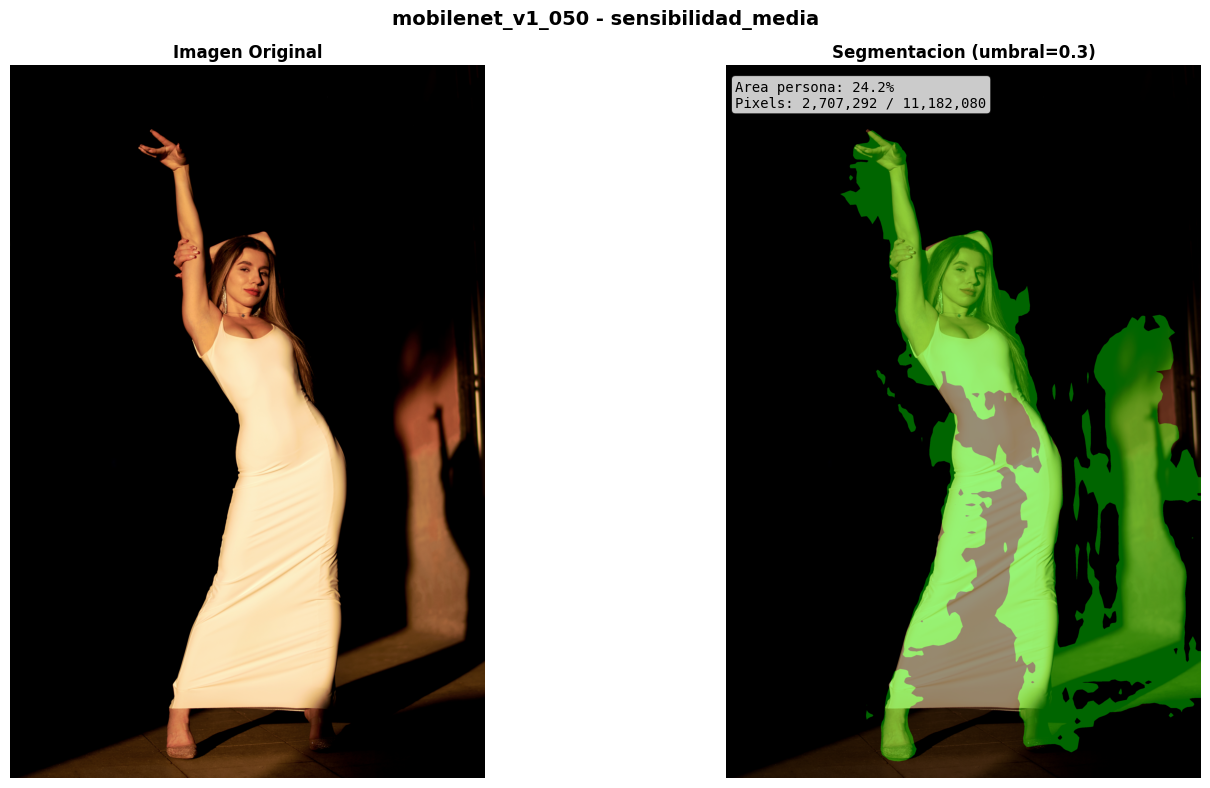

In [50]:
if __name__ == "__main__":
    main()

In [34]:
# ==============================================================================
# TEST DIAGNÓSTICO AISLADO - EJECUTA ESTO EN UNA CELDA SEPARADA
# ==============================================================================

from tf_bodypix.api import download_model, load_model, BodyPixModelPaths
import cv2
import numpy as np

# Cargar modelo
print("Cargando modelo...")
model_path = download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16)
model = load_model(model_path)
print("Modelo cargado\n")

img_path = "/content/drive/MyDrive/TFM/0_Imagenes/_DSC0023.jpg"
print(f"Cargando imagen: {img_path}")

img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print(f"Imagen: {img_rgb.shape}, {img_rgb.dtype}, [{img_rgb.min()}, {img_rgb.max()}]\n")

# Inferencia
print("Haciendo inferencia...")
result = model.predict_single(img_rgb)
print("Inferencia completada\n")

print("Resultados por threshold:")
print("-" * 60)

for t in [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]:
    mask = result.get_mask(threshold=t)

    # Verificar tipo
    print(f"\nThreshold {t}:")
    print(f"  Tipo de mask: {type(mask)}")

    # Convertir a numpy
    if hasattr(mask, 'numpy'):
        mask_np = mask.numpy()
    else:
        mask_np = np.array(mask)

    print(f"  Shape: {mask_np.shape}")
    print(f"  Dtype: {mask_np.dtype}")
    print(f"  Range: [{mask_np.min()}, {mask_np.max()}]")

    # Asegurar 2D
    if mask_np.ndim == 3:
        mask_np = mask_np[:, :, 0]

    # Contar pixels
    area = (mask_np > 0).sum()
    total = mask_np.size
    pct = (area / total) * 100

    print(f"  Pixels detectados: {area:,} ({pct:.1f}%)")
    print(f"  Valores únicos: {np.unique(mask_np)}")

print("\n" + "=" * 60)

Cargando modelo...
Modelo cargado

Cargando imagen: /content/drive/MyDrive/TFM/0_Imagenes/_DSC0023.jpg
Imagen: (6000, 4000, 3), uint8, [0, 255]

Haciendo inferencia...
Inferencia completada

Resultados por threshold:
------------------------------------------------------------

Threshold 0.05:
  Tipo de mask: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (6000, 4000, 1)
  Dtype: int32
  Range: [0, 1]
  Pixels detectados: 18,328,217 (76.4%)
  Valores únicos: [0 1]

Threshold 0.1:
  Tipo de mask: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (6000, 4000, 1)
  Dtype: int32
  Range: [0, 1]
  Pixels detectados: 15,992,715 (66.6%)
  Valores únicos: [0 1]

Threshold 0.15:
  Tipo de mask: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (6000, 4000, 1)
  Dtype: int32
  Range: [0, 1]
  Pixels detectados: 14,435,880 (60.1%)
  Valores únicos: [0 1]

Threshold 0.2:
  Tipo de mask: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (6000, 